In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Plot performance metrics
def _plot_box(model_folders, model_names, testg_suffixes, model_colors, fold_index=[0, 1], metric_col='pearsonr', descr_filter=None, plot_title=None, figsize=(4, 3), box_perc=5., ymin=None, ymax=None, yticks=None, save_suffix=None) :
    
    acc_dfs = []

    #Loop over folds
    for fold_ix in fold_index :

        acc_df_agg = None

        #Loop over model folders and load accuracy dataframes (multiple folds)
        for model_folder, model_name, testg_suffix in zip(model_folders, model_names, testg_suffixes) :

            acc_df = pd.read_csv(model_folder + '/f' + str(fold_ix) + 'c0/testg' + testg_suffix + '/acc.txt', index_col=0, sep='\t')[['identifier', 'description'] + [metric_col]]
            acc_df = acc_df.rename(columns={metric_col : metric_col + '_' + model_name})

            #Optionally apply extra filter on descriptions
            if descr_filter is not None and descr_filter != '' :
                acc_df = acc_df.loc[acc_df['description'].str.contains(descr_filter)].copy()

            acc_df = acc_df[['identifier'] + [metric_col + '_' + model_name]]

            if acc_df_agg is None :
                acc_df_agg = acc_df
            else :
                acc_df_agg = acc_df_agg.join(acc_df.set_index('identifier'), on='identifier', how='inner').copy().reset_index(drop=True)

        acc_dfs.append(acc_df_agg)

    #Calculate average over dataframes (folds)
    acc_df = acc_dfs[0].copy()
    for fold_ix in range(1, len(acc_dfs)) :
        for model_name in model_names :
            acc_df[metric_col + '_' + model_name] += acc_dfs[fold_ix][metric_col + '_' + model_name]

    for model_name in model_names :
        acc_df[metric_col + '_' + model_name] /= len(acc_dfs)

    #Plot boxplots of performance metrics per model

    acc_vals = np.array(acc_df.values[:, 1:], dtype='float32')

    f = plt.figure(figsize=figsize)

    n = acc_vals.shape[0]
    min_p = (n / 100.) * box_perc
    max_p = 100. - (n / 100.) * box_perc

    sns.boxplot(data=acc_vals, palette=model_colors, fliersize=0., whis=(min_p, max_p))
    sns.stripplot(data=acc_vals, palette=model_colors, alpha=0.9, s=4, zorder=-1)

    plt.xticks(np.arange(len(model_names), dtype='int32'), model_names, fontsize=8)
    if yticks is None :
        plt.yticks(fontsize=8)
    else :
        plt.yticks(yticks, fontsize=8)
    plt.ylabel(metric_col, fontsize=8)
    
    if plot_title is not None :
        plt.title(plot_title + ', n = ' + str(n), fontsize=8)
    else :
        plt.title('n = ' + str(n), fontsize=8)

    if ymin is not None and ymax is not None :
        plt.ylim(ymin, ymax)

    plt.tight_layout()
    
    if save_suffix is not None :
        plt.savefig('boxplot' + save_suffix + '.png', dpi=600)
        plt.savefig('boxplot' + save_suffix + '.eps')

    plt.show()

    return acc_df


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


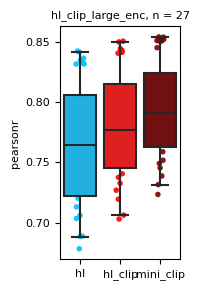

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


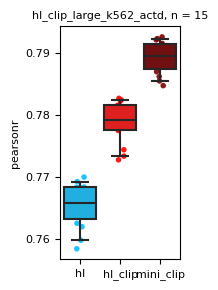

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


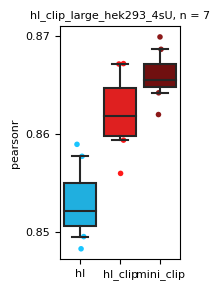

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


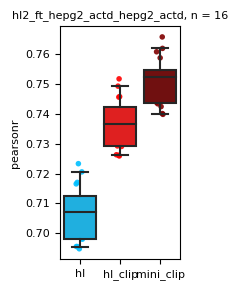

In [2]:
#Compare model accuracies

plot_title = 'hl_clip'
metric_col = 'pearsonr'
descr_filter = '(RNA:ActD:K562.*)|(RNA:ActD:HEK293.*)|(RNA:ActD:HepG2.*)|(RNA:4sU:K562.*)|(RNA:4sU:HEK293.*)|(RNA:4sU:HepG2.*)'

model_names = [
    'hl',
    'hl_clip',
    'mini_clip',
]

model_folders = [
    'hl_micro/models',
    'hl_clip_micro/models',
    'hl_clip/models',
]

testg_suffixes = [
    '-0',
    '-0',
    '-0',
]

model_colors = [
    'deepskyblue',
    'red',
    'maroon',
]

#Compare model accuracies (baseline encode data)

descr_filter = '(RNA:K562.*)|(RNA:HepG2.*)|(RNA:4sU:HEK293 total RNA)|(RNA:ActD:HEK293T Control for .*)|(RNA:ActD:HEK293T 293t_0h_.*)'

_ = _plot_box(
    model_folders,
    model_names,
    testg_suffixes,
    model_colors,
    metric_col=metric_col,
    descr_filter=descr_filter,
    plot_title=plot_title + '_enc',
    box_perc=2.,
    figsize=(2, 3),
    #ymin=0.675,
    #ymax=0.875,
    yticks=[0.70, 0.75, 0.80, 0.85],
    save_suffix='_mini_encode'
)

#Compare model accuracies (k562 only)

descr_filter = 'RNA:ActD:K562__'

_ = _plot_box(
    model_folders,
    model_names,
    testg_suffixes,
    model_colors,
    metric_col=metric_col,
    descr_filter=descr_filter,
    plot_title=plot_title + '_k562_actd',
    box_perc=2.,
    figsize=(2, 3),
    yticks=[0.76, 0.77, 0.78, 0.79],
    save_suffix='_mini_actd_k562'
)

#Compare model accuracies (hek293 only)

descr_filter = 'RNA:4sU:HEK293_.*_R1'

_ = _plot_box(
    model_folders,
    model_names,
    testg_suffixes,
    model_colors,
    metric_col=metric_col,
    descr_filter=descr_filter,
    plot_title=plot_title + '_hek293_4sU',
    box_perc=2.,
    figsize=(2, 3),
    yticks=[0.85, 0.86, 0.87],
    save_suffix='_mini_4su_hek293'
)

#Compare model accuracies (hepg2 only)

descr_filter = 'RNA:ActD:HepG2_sh.*_.*_rep.*'

_ = _plot_box(
    model_folders,
    model_names,
    testg_suffixes,
    model_colors,
    metric_col=metric_col,
    descr_filter=descr_filter,
    plot_title=plot_title + '_hepg2_actd',
    box_perc=2.,
    figsize=(2, 3),
    yticks=[0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76],
    save_suffix='_mini_actd_hepg2'
)
